In [2]:
using Pkg
using Flux
using Hopfields
using HDF5
using PyCall

ENV["PYTHON"] = "/Users/dongyu/opt/anaconda3/envs/modeling/bin/python"
Pkg.build("PyCall")
println(PyCall.python)

    Building Conda ─→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/51cab8e982c5b598eea9c8ceaced4b58d9dd37c9/build.log`


    Building PyCall → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/1cb97fa63a3629c6d892af4f76fcc4ad8191837c/build.log`


/Users/dongyu/opt/anaconda3/envs/modeling/bin/python


In [82]:
function load_shapes3d_dataset(file_path)
    # randomly sample 10 integers from 1 to 480000
    random_idx = rand(1:480000, 100)
    dataset = h5open(file_path, "r") do file
        read(file["images"])[:, :, :, random_idx]
    end
    dataset = permutedims(dataset, [4, 3, 2, 1])
    println("Dataset shape: ", size(dataset))
    # Convert and reshape the dataset to a list of 1d vectors
    converted_dataset = ((dataset ./ 255) .* 2) .- 1
    converted_dataset = [reshape(converted_dataset[i,:,:,:], (64*64*3,1)) for i in 1:size(converted_dataset)[1]]
    println("Converted dataset shape: ", size(converted_dataset))
    return dataset, converted_dataset
end
;

In [83]:
# Load the dataset
dataset,converted_dataset = load_shapes3d_dataset("3dshapes.h5")

Dataset shape: (100, 64, 64, 3)
Converted dataset shape: (100,)


([0x99 0x99 … 0x00 0x00; 0x99 0x99 … 0xff 0xff; … ; 0x99 0x99 … 0xd2 0xc9; 0x99 0x99 … 0x00 0x00;;; 0x99 0x99 … 0x00 0x00; 0x99 0x99 … 0xff 0xff; … ; 0x99 0x99 … 0xd1 0xc9; 0x99 0x99 … 0x00 0x00;;; 0x99 0x99 … 0x00 0x00; 0x99 0x99 … 0xff 0xff; … ; 0x99 0x99 … 0xd1 0xc7; 0x99 0x99 … 0x00 0x00;;; … ;;; 0x99 0x99 … 0x00 0x00; 0x99 0x99 … 0xec 0xec; … ; 0x99 0x99 … 0xb0 0xae; 0x99 0x99 … 0x00 0x00;;; 0x99 0x99 … 0x00 0x00; 0x99 0x99 … 0xea 0xea; … ; 0x99 0x99 … 0xaf 0xae; 0x99 0x99 … 0x00 0x00;;; 0x99 0x99 … 0x00 0x00; 0x99 0x99 … 0xe9 0xe9; … ; 0x99 0x99 … 0xaf 0xad; 0x99 0x99 … 0x00 0x00;;;; 0xe2 0xe2 … 0x65 0x67; 0xe2 0xe2 … 0xbc 0xb2; … ; 0xe2 0xe2 … 0xfe 0xfa; 0xe2 0xe2 … 0xfe 0xfa;;; 0xe2 0xe2 … 0x62 0x63; 0xe2 0xe2 … 0xba 0xb0; … ; 0xe2 0xe2 … 0xfe 0xfa; 0xe2 0xe2 … 0xfe 0xfa;;; 0xe2 0xe2 … 0x63 0x61; 0xe2 0xe2 … 0xb8 0xb6; … ; 0xe2 0xe2 … 0xfe 0xf8; 0xe2 0xe2 … 0xfe 0xf8;;; … ;;; 0xe2 0xe2 … 0x58 0x58; 0xe2 0xe2 … 0x8e 0x8e; … ; 0xe2 0xe2 … 0xdb 0xd9; 0xe2 0xe2 … 0xdb 0xd9;;; 0xe2 

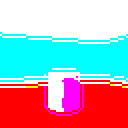

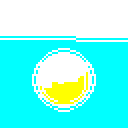

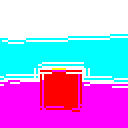

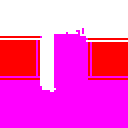

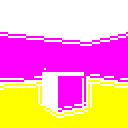

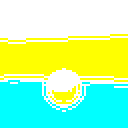

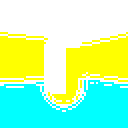

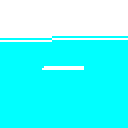

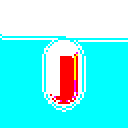

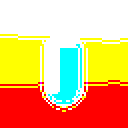

In [104]:
# show the images in the dataset
using Images
function show_images(dataset)
    random_idx = rand(1:100, 10)
    for i in random_idx
        img = dataset[i,:,:,:]
        img = permutedims(img, [3,1,2])
        img_float = float(img) # Convert image to float
        display(Images.colorview(RGB, img_float))
    end
end

# show the images in the dataset
show_images(dataset)


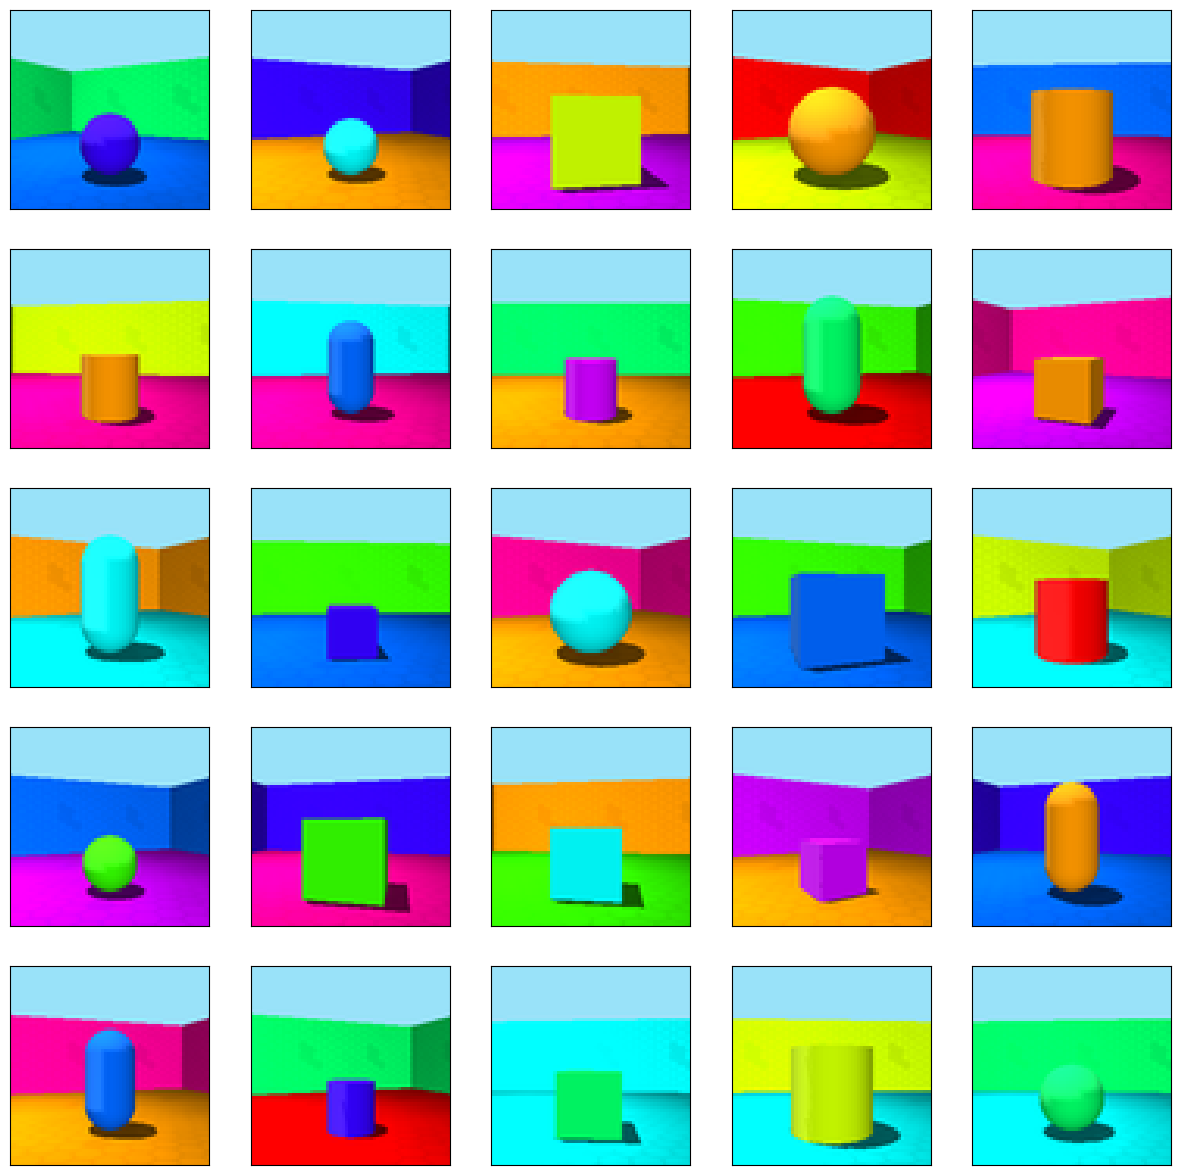

In [102]:
py"""
import numpy as np
import matplotlib.pyplot as plt
def show_images_grid(imgs_, num_images=25):
  imgs_ = imgs_ / 255. # normalise values to range [0,1]
  imgs_ = imgs_.astype(np.float32)
  ncols = int(np.ceil(num_images**0.5))
  nrows = int(np.ceil(num_images / ncols))
  fig, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
  axes = axes.flatten()

  for ax_i, ax in enumerate(axes):
    if ax_i < num_images:
      ax.imshow(imgs_[ax_i], cmap='Greys_r', interpolation='nearest')
      ax.set_xticks([])
      ax.set_yticks([])
    else:
      ax.axis('off')
  return fig
"""

display(py"show_images_grid"(dataset))

# Util functions

In [93]:

py"""
import tqdm
import matplotlib.pyplot as plt
from scipy.special import softmax
import tensorflow_datasets as tfds

def mask_image_random(n):
    random_arrays = []
    for i in range(n):
        random_array = np.random.uniform(-1, 1, size=(64, 64, 3))
        random_arrays.append(random_array)
    return random_arrays

def display(array1, array2, seed=None, title='Inputs and outputs of the model', n=10):
    hopfield = False

    dim = array1[0].shape[0]
    # Displays ten random images from each one of the supplied arrays.
    if seed is not None:
        np.random.seed(seed)

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    fig = plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        if hopfield is True:
            plt.imshow(image1.reshape(dim, dim), cmap='binary', vmin=-1, vmax=1)
        else:
            plt.imshow(image1.reshape(dim, dim, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        if hopfield is True:
            plt.imshow(image2.reshape(dim, dim), cmap='binary', vmin=-1, vmax=1)
        else:
            plt.imshow(image2.reshape(dim, dim, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig.suptitle(title)
    plt.show()
    return fig

def load_tfds_dataset(dataset, num=15000, labels=False, key_dict={'shapes3d': 'label_shape'}):
    dim = dims_dict[dataset]
    ds = tfds.load(dataset, split='train', shuffle_files=False, data_dir='./data/')
    ds_info = tfds.builder(dataset).info
    df = tfds.as_dataframe(ds.take(num), ds_info)
    data = df['image'].tolist()

    key = key_dict[dataset]
    labels_arr = df[key].to_numpy()

    train_data, test_data, train_labels, test_labels = train_test_split(data, labels_arr, test_size=0.1,
                                                                        random_state=42)

    train_data = np.array(train_data).reshape(len(train_data), dim[0], dim[1], 3)
    test_data = np.array(test_data).reshape(len(test_data), dim[0], dim[1], 3)

    if labels:
        return train_data, test_data, train_labels, test_labels
    else:
        return train_data, test_data


def prepare_data(dataset, display=False, noise_factor=0.6, labels=False):
    if labels is True:
        train_data, test_data, train_labels, test_labels = load_tfds_dataset(dataset, labels=True)
    if labels is False:
        train_data, test_data = load_tfds_dataset(dataset, labels=False)

    # Normalize and reshape the data
    train_data = preprocess(train_data)
    test_data = preprocess(test_data)

    # Create a copy of the data with added noise
    noisy_train_data = noise(train_data, noise_factor=noise_factor)
    noisy_test_data = noise(test_data, noise_factor=noise_factor)

    # Display the train data and a version of it with added noise
    if display is True:
        display(train_data, noisy_train_data)

    if labels is True:
        return train_data, test_data, noisy_train_data, noisy_test_data, train_labels, test_labels
    if labels is False:
        return train_data, test_data, noisy_train_data, noisy_test_data

def plot_history(history, decoding_history, titles=False):
    recon_loss_values = history.history['reconstruction_loss']
    decoding_acc_values = decoding_history.decoding_history
    epochs = range(1, len(recon_loss_values) + 1)

    fig, ax = plt.subplots(figsize=(3, 3))
    ax2 = ax.twinx()
    ax2.set_ylim(0, 1)
    ax.set_ylabel("Reconstruction error")
    ax2.set_ylabel("Decoding accuracy")

    ax.plot(epochs, recon_loss_values, label='Reconstruction Error', color='red')
    ax2.plot(epochs, decoding_acc_values, label='Decoding Accuracy', color='blue')

    if titles is True:
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc=0)
        plt.title('Reconstruction error and decoding accuracy over time')

    ax.set_xlabel('Epoch')
    plt.show()
    return fig

def check_generative_recall(vae, test_data, noise_level=0.1):
    test_data = noise(test_data, noise_factor=noise_level)
    latents = vae.encoder.predict(test_data)
    predictions = vae.decoder.predict(latents[0])
    fig = display(test_data, predictions, title='Inputs and outputs for VAE')
    return fig
"""


# Hopfield network

In [68]:
py"""
import numpy as np
import tensorflow as tf
class ContinuousHopfield:
    def __init__(self, pat_size, beta=100, do_normalization=True):
        self.size = pat_size  # size of individual pattern
        self.beta = beta
        print(self.beta)
        self.max_norm = np.sqrt(self.size)
        if do_normalization:
            self.softmax = self.softmax_normalized
            self.energy = self.energy_normalized
        else:
            self.softmax = self.softmax_unnormalized
            self.energy = self.energy_unnormalized

        return

    def learn(self, patterns):
        # expects patterns as numpy arrays and stores them col-wise in pattern matrix 
        self.num_pat = len(patterns)
        assert (all(type(x) is np.ndarray for x in patterns)), 'not all input patterns are numpy arrays'
        assert (all(len(x.shape) == 2 for x in patterns)), 'not all input patterns have dimension 2'
        assert (all(1 == x.shape[1] for x in patterns)), 'not all input patterns have shape (-1,1) '
        self.patterns = np.array(patterns).squeeze(axis=-1).T  # save patterns col-wise
        # without squeeze axis would result in problem with one pattern
        # return -1*np.sum(np.exp([(self.patterns[:,ii].T @pattern)/self.max_norm for ii in range(self.patterns.shape[1])]))
        self.M = max(np.linalg.norm(vec) for vec in patterns)  # maximal norm of actually stored patterns
        return

    def retrieve(self, partial_pattern, max_iter=np.inf, thresh=0.5):
        # partial patterns have to be provided with None/0 at empty spots
        if partial_pattern.size != self.size:
            raise ValueError("Input pattern %r does not match state size: %d vs %d"
                             % (partial_pattern, len(partial_pattern), self.size))

        if None in partial_pattern:
            raise NotImplementedError("None elements not supported")

        assert type(partial_pattern) == np.ndarray, 'test pattern was not numpy array'
        assert len(partial_pattern.shape) == 2 and 1 == partial_pattern.shape[
            1], 'test pattern with shape %r is not a col-vector' % (partial_pattern.shape,)

        pat_old = partial_pattern.copy()
        iters = 0

        while iters < max_iter:
            pat_new = self.patterns @ self.softmax(self.beta * self.patterns.T @ pat_old)

            if np.count_nonzero(pat_old != pat_new) <= thresh:  # converged
                break
            else:
                pat_old = pat_new
            iters += 1

        return pat_new

    def softmax_unnormalized(z):
        return softmax(z)  # Scipy's softmax is numerically stable

    def softmax_normalized(self, z):
        return softmax(z / self.max_norm)

    @staticmethod
    def _lse(z, beta):
        return 1 / beta * np.log(np.sum(np.exp(beta * z)))

    def energy_unnormalized(self, pattern):
        return -1 * self._lse(self.patterns.T @ pattern, 1) + 0.5 * pattern.T @ pattern \
            + 1 / self.beta * np.log(self.num_pat) \
            + 0.5 * self.M ** 2

    def energy_normalized(self, pattern):
        # normalize dot product of patterns by 1/sqrt(pattern_size)
        return -1 * self._lse((self.patterns.T @ pattern) / self.max_norm, 1) + 0.5 * pattern.T @ pattern \
            + 1 / self.beta * np.log(self.num_pat) \
            + 0.5 * self.M ** 2

    def energy_landscape(self):
        for pat in product([1, -1], repeat=self.size):
            pat = np.array(pat)
            print("energy(%r)=%.3f" % (pat, self.energy(pat)))


"""

In [89]:
pat_size = 64*64*3
net = py"ContinuousHopfield"(pat_size)
net.learn(converted_dataset)


In [105]:
n = 10
np = py"np"
images_masked_np = py"mask_image_random"(n)
println("shape before reshaping: ", size(images_masked_np[1]))
images_masked_np = [reshape(array, (64*64*3,1)) for array in images_masked_np]
println("shape after reshaping: ", size(images_masked_np[1]))

print("Sampling from modern Hopfield network.")
predictions = []
tests = []
for test_ind in 1:n
    test = images_masked_np[test_ind]
    reconstructed = net.retrieve(test, max_iter=10)

    reconstructed = reshape(reconstructed, (1, 64, 64, 3))
    push!(predictions, reconstructed)
    test = reshape(test, (1, 64, 64, 3))
    push!(tests, test)
end

predictions = np.concatenate(predictions, axis=0)
tests = np.concatenate(tests, axis=0)

display(py"display"(tests, predictions,n=n, title="Inputs and outputs of the Hopfield network"))

# rescale predictions back to interval [0, 1]
predictions = (predictions .+ 1) / 2

# save the predictions
using JLD
save("predictions.jld", "predictions", predictions)

shape before reshaping: (64, 64, 3)
shape after reshaping: 

(12288, 1)
Sampling from modern Hopfield network.

# Variational Autoencoder


In [87]:
py"""
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from tensorflow import keras
from tensorflow.keras import layers

class VAE(keras.Model):

    def __init__(self, encoder, decoder, kl_weighting=1, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.kl_weighting = kl_weighting
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = reconstruction_loss_fn(data, reconstruction)
            kl_loss = kl_loss_fn(z_mean, z_log_var, self.kl_weighting)
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

def label_classifier(latents, labels, num=200):
        np.random.seed(1)
        x_train, x_test, y_train, y_test = train_test_split(latents[0], labels,
                                                            test_size=0.5, random_state=1)
        clf = make_pipeline(StandardScaler(), SVC())
        clf.fit(x_train[0:num], y_train[0:num])
        score = clf.score(x_test, y_test)
        return score
    
class DecodingHistory(keras.callbacks.Callback):
    
        def __init__(self, dataset):
            _, self.test_data, _, _, _, self.test_labels = prepare_data(dataset, labels=True)
            self.decoding_history = []
    
        def on_epoch_begin(self, epoch, logs=None):
            latents = self.model.encoder.predict(self.test_data)
            score = label_classifier(latents, self.test_labels)
            self.decoding_history.append(score)
    
    
class Sampling(layers.Layer):
        # Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
    
        def call(self, inputs):
            z_mean, z_log_var = inputs
            batch = tf.shape(z_mean)[0]
            dim = tf.shape(z_mean)[1]
            epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
            return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def encoder_network_large(input_shape, latent_dim=100):
    input_img = layers.Input(shape=input_shape)
    x = layers.Dropout(0.2, input_shape=input_shape)(input_img)
    x = layers.Conv2D(32, 4, strides=(2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(64, 4, strides=(2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(128, 4, strides=(2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(256, 4, strides=(2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.GlobalAveragePooling2D()(x)

    z_mean = layers.Dense(latent_dim, name='mean')(x)
    z_log_var = layers.Dense(latent_dim)(x)
    z = Sampling()([z_mean, z_log_var])

    encoder = keras.Model(input_img, [z_mean, z_log_var, z], name="encoder")
    return encoder, z_mean, z_log_var


def decoder_network_large(latent_dim=100):
    decoder_input = layers.Input(shape=(latent_dim,))
    x = layers.Dense(4096)(decoder_input)
    x = layers.Reshape((4, 4, 256))(x)

    x = layers.UpSampling2D((2, 2), interpolation='nearest')(x)
    x = layers.Conv2D(128, 3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.UpSampling2D((2, 2), interpolation='nearest')(x)
    x = layers.Conv2D(64, 3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.UpSampling2D((2, 2), interpolation='nearest')(x)
    x = layers.Conv2D(32, 3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.UpSampling2D((2, 2), interpolation='nearest')(x)
    x = layers.Conv2D(3, 3, strides=1, padding='same', activation='sigmoid')(x)

    decoder = keras.Model(decoder_input, x)
    return decoder


def build_encoder_decoder_large(latent_dim=5):
    input_shape = (64, 64, 3)
    encoder, z_mean, z_log_var = encoder_network_large(input_shape, latent_dim)
    decoder = decoder_network_large(latent_dim)
    return encoder, decoder

def kl_loss_fn(z_mean, z_log_var, kl_weighting):
    # take the sum across the n latent variables
    # then take the mean across the batch
    kl = K.mean(-0.5 * K.sum(1 + z_log_var \
                             - K.square(z_mean) \
                             - K.exp(z_log_var), axis=-1))
    return kl_weighting * kl


def reconstruction_loss_fn(x, t_decoded):
    # mean_absolute_error() returns result of dim (n_in_batch, pixels)
    # take the sum across the 64x64x3 pixels
    # take the mean across the batch
    data = x
    reconstruction = t_decoded
    # note that binary_crossentropy loss also gives good results
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(
        keras.losses.mean_absolute_error(data, reconstruction), axis=(1, 2)))
    return reconstruction_loss
"""

In [ ]:
latent_dim = 5
keras = py"keras"
kl_weighting=1
lr=0.001
generative_epochs=10
pickle = pyimport("pickle")
dataset = "shapes3d"
print("Starting to train VAE.")
# build VAE with latent_dim latent variables
encoder, decoder = py"build_encoder_decoder_large"(latent_dim=latent_dim)
vae = py"VAE"(encoder, decoder, kl_weighting)
# jit_compile set to False to run on MacOS
opt = keras.optimizers.Adam(lr=lr, amsgrad=True, jit_compile=False)
vae.compile(optimizer=opt)
decoding_history = py"DecodingHistory"(dataset)
history = keras.callbacks.History()
# stop training if no loss improvement for three epochs
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
print("Input data shape:", predictions.shape)
vae.fit(predictions, epochs=generative_epochs, verbose=2, batch_size=32, shuffle=True,
        callbacks=[history, decoding_history, early_stopping])

vae.encoder.save_weights("model_weights/{}_encoder.h5".format(dataset))
vae.decoder.save_weights("model_weights/{}_decoder.h5".format(dataset))

diplay(py"plot_history"(history, decoding_history))

pickle.dump(history.history['reconstruction_loss'], open("./outputs/history.pkl", "wb"))
pickle.dump(decoding_history.decoding_history, open("./outputs/decoding.pkl", "wb"))

print("Recalling noisy images with the generative model:")
fig = check_generative_recall(vae, train_data[0:100])
pdf.savefig(fig)

latents = vae.encoder.predict(test_data)